In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

#CIFAR10 Dataset

CIFAR-10 is a popular dataset in the field of machine learning, especially for image classification tasks. It consists of 60,000 32x32 color images in 10 different classes, with 6,000 images per class. The dataset is divided into 50,000 training images and 10,000 testing images, covering categories such as airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. CIFAR-10 is widely used for benchmarking algorithms due to its relatively small size, making it suitable for rapid experimentation and testing of neural networks, particularly in the domain of computer vision.

In [2]:
# Define data transformations (resize, normalize, etc.)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224 for AlexNet
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

# Load CIFAR-10 training and validation datasets
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
val_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


#AlexNet Architecture

**AlexNet** is a pioneering convolutional neural network (CNN) architecture that played a key role in advancing deep learning, especially in the field of computer vision. Introduced by Alex Krizhevsky in 2012, AlexNet won the ImageNet Large Scale Visual Recognition Challenge (ILSVRC), significantly outperforming traditional machine learning models at the time.

### Key Features:
- **Deep Convolutional Layers**: AlexNet consists of 5 convolutional layers followed by 3 fully connected layers, designed to automatically extract hierarchical features from images.
- **ReLU Activation**: It popularized the use of Rectified Linear Units (ReLU), which speed up training compared to traditional activation functions like sigmoid or tanh.
- **Dropout**: AlexNet introduced dropout to mitigate overfitting by randomly deactivating neurons during training.
- **Max Pooling**: It employs max-pooling layers for downsampling while preserving important features.

### Applications:
- **Image Classification**: AlexNet is primarily used for image classification tasks, where it can categorize objects into various classes (e.g., from ImageNet).
- **Object Detection and Recognition**: Variants of AlexNet are applied in object detection tasks, recognizing and localizing objects in images.
- **Transfer Learning**: AlexNet is widely used in transfer learning, where pre-trained models on large datasets like ImageNet are fine-tuned for new tasks or smaller datasets.

While newer architectures (like ResNet or EfficientNet) have surpassed AlexNet in performance, it remains foundational in the development of CNNs.


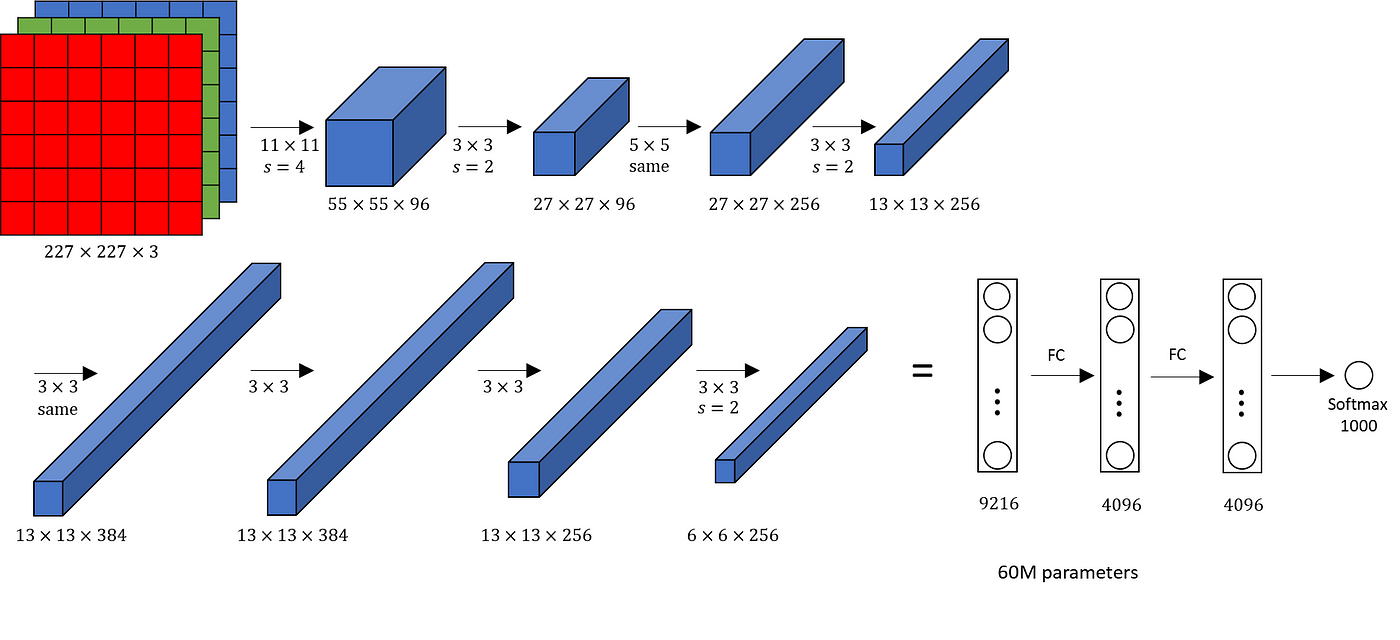

In [3]:
# Define the AlexNet architecture
class AlexNet(nn.Module):
    def __init__(self, num_classes=200):  # We use 200 classes for Tiny ImageNet
        super(AlexNet, self).__init__()
        # Features extraction layers
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),  # First convolution layer
            nn.ReLU(inplace=True),  # Activation function
            nn.MaxPool2d(kernel_size=3, stride=2),  # First max pooling layer
            nn.Conv2d(64, 192, kernel_size=5, padding=2),  # Second convolution layer
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),  # Second max pooling layer
            nn.Conv2d(192, 384, kernel_size=3, padding=1),  # Third convolution layer
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),  # Fourth convolution layer
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),  # Fifth convolution layer
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),  # Third max pooling layer

        )

        self.classifier = nn.Sequential(
            nn.Dropout(),   # Dropout to prevent overfitting
            nn.Linear(256 * 6 * 6, 4096),  # First fully connected layer
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),  # Second fully connected layer
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),  # Set to 200 classes for Tiny ImageNet
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256 * 6 * 6)  # Flatten the tensor for the classifier
        x = self.classifier(x)      # Pass through the fully connected layers
        return x


#Training Model

In [4]:
# Check if a GPU is available, and if not, use the CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the AlexNet model and move it to the GPU/CPU
model = AlexNet(num_classes=200).to(device)

# Define the loss function (cross-entropy loss for classification)
criterion = nn.CrossEntropyLoss()

# Define the optimizer (SGD with momentum and weight decay)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)

# Set the number of epochs for training
num_epochs = 10

# Lists to store training loss and validation accuracy for each epoch
training_losses = []
validation_losses = []

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU/CPU

        optimizer.zero_grad()  # Clear the gradients from the previous iteration
        outputs = model(inputs)  # Forward pass through the network
        loss = criterion(outputs, labels)  # Compute the loss
        loss.backward()  # Backward pass to compute gradients
        optimizer.step()  # Update the model parameters

        running_loss += loss.item()  # Accumulate the loss

    # Compute average training loss for this epoch
    average_loss = running_loss / len(train_loader)
    training_losses.append(average_loss)  # Store average training loss
    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {average_loss:.4f}')

    # Validation loop (evaluate on validation data)
    model.eval()  # Set model to evaluation mode
    val_running_loss = 0.0
    with torch.no_grad():  # Disable gradient computation for validation
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)  # Forward pass through the network
            loss = criterion(outputs, labels)  # Compute validation loss
            val_running_loss += loss.item()

    # Compute average validation loss for this epoch
    average_val_loss = val_running_loss / len(val_loader)
    validation_losses.append(average_val_loss)  # Store average validation loss
    print(f'Validation Loss: {average_val_loss:.4f}')

Epoch [1/10], Training Loss: 2.9201
Validation Loss: 2.0948
Epoch [2/10], Training Loss: 1.9290
Validation Loss: 1.7332
Epoch [3/10], Training Loss: 1.6616
Validation Loss: 1.5727
Epoch [4/10], Training Loss: 1.5454
Validation Loss: 1.5182
Epoch [5/10], Training Loss: 1.4272
Validation Loss: 1.3581
Epoch [6/10], Training Loss: 1.3405
Validation Loss: 1.2380
Epoch [7/10], Training Loss: 1.2589
Validation Loss: 1.1822
Epoch [8/10], Training Loss: 1.1716
Validation Loss: 1.1444
Epoch [9/10], Training Loss: 1.0895
Validation Loss: 1.0532
Epoch [10/10], Training Loss: 1.0173
Validation Loss: 0.9530


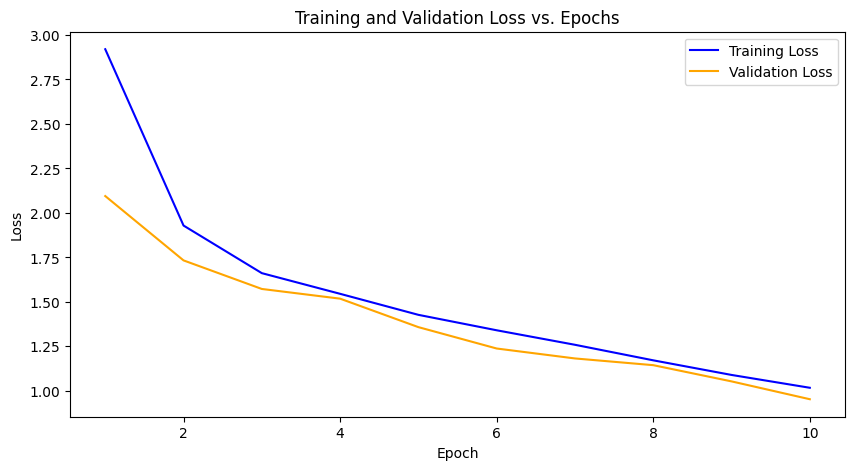

In [5]:
import matplotlib.pyplot as plt

# Plot Training Loss and Validation Loss on the same plot
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), training_losses, label='Training Loss', color='blue')
plt.plot(range(1, num_epochs + 1), validation_losses, label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss vs. Epochs')
plt.legend()
plt.show()